In [1]:
COLLAB = True # False True

In [2]:

if COLLAB:
    !pip install langdetect
    from google.colab import drive
    import pandas as pd
    drive.mount("/content/drive")
    df = pd.read_csv('/content/drive/MyDrive/full_merged_dataset15.csv', encoding='utf-8')

    from IPython.display import HTML, display

    def set_css():
        display(HTML('''
        <style>
            pre {
                white-space: pre-wrap;
            }
        </style>
        '''))
        get_ipython().events.register('pre_run_cell', set_css)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import pandas as pd
import os
import numpy as np
from termcolor import colored
import seaborn as sns
import matplotlib.pyplot as plt
import html
from langdetect import detect
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
import gc
from wordcloud import WordCloud
from gensim.models.phrases import Phrases
from nltk.tokenize import wordpunct_tokenize
from nltk.tokenize import sent_tokenize
import re
import nltk

In [4]:
def check_nltk_packages():
  packages = ['punkt','stopwords','omw-1.4','wordnet']

  for package in packages:
    try:
      nltk.data.find('tokenizers/' + package)
    except LookupError:
      nltk.download(package)
check_nltk_packages()

try:
  import lxml
except ModuleNotFoundError:
  %pip install lxml

try:
  import contractions
except ModuleNotFoundError:
  %pip install contractions
  import contractions

from bs4 import BeautifulSoup
import re

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Preprocessing

In [5]:
#df = pd.read_csv('Datasets/full_merged_dataset15.csv', encoding='utf-8')
df = df.dropna(subset=['poem'])

In [6]:
df.head()

id                         title                   author  \
0  162275   The 80&rsquo;s Miracle Diet          By Melvin Dixon   
1  162250             All Saints&rsquo;  By Corey Van Landingham   
2  162279  And These Are Just a Few ...          By Melvin Dixon   
3  162248                          ASMR  By Corey Van Landingham   
4  162249                          ASMR  By Corey Van Landingham   

                                             snippet  \
0                      Yours free without the asking   
1    CaravaggioÃ¢â‚¬â„¢s face in the sunken pumpkin.   
2  This poem is for the epidemic dead and the liv...   
3                      Why not climb up the mountain   
4                               HelloÃ¢â‚¬â€Tonight   

                                                link  \
0  https://www.poetryfoundation.org/poetrymagazin...   
1  https://www.poetryfoundation.org/poetrymagazin...   
2  https://www.poetryfoundation.org/poetrymagazin...   
3  https://www.poetryfoundation.org/poetrymagazin...   
4  https://www.poetryfoundation.org/poetrymagazin...   

                                          categories  \
0                     ['Living', 'Health & Illness']   
1                                                 []   
2  ['Living', 'Health & Illness', 'Social Comment...   
3                                                 []   
4                                                 []   

                                                poem  
0  Yours free without the asking Quick delivery v...  
1  CaravaggioÃ¢â‚¬â„¢s face in the sunken pumpkin...  
2  This poem is for the epidemic dead and the liv...  
3  Why not climb up the mountain of delight? To t...  
4  HelloÃ¢â‚¬â€Tonight weÃ¢â‚¬â„¢ll trace the st...

We can remove the id, snippet and link as they are useless for the tasks we have to do.

In [7]:
columns_to_drop = ["id", "snippet", "link"]
df.drop(columns=columns_to_drop, inplace=True)

In [8]:
df.head()

title                   author  \
0   The 80&rsquo;s Miracle Diet          By Melvin Dixon   
1             All Saints&rsquo;  By Corey Van Landingham   
2  And These Are Just a Few ...          By Melvin Dixon   
3                          ASMR  By Corey Van Landingham   
4                          ASMR  By Corey Van Landingham   

                                          categories  \
0                     ['Living', 'Health & Illness']   
1                                                 []   
2  ['Living', 'Health & Illness', 'Social Comment...   
3                                                 []   
4                                                 []   

                                                poem  
0  Yours free without the asking Quick delivery v...  
1  CaravaggioÃ¢â‚¬â„¢s face in the sunken pumpkin...  
2  This poem is for the epidemic dead and the liv...  
3  Why not climb up the mountain of delight? To t...  
4  HelloÃ¢â‚¬â€Tonight weÃ¢â‚¬â„¢ll trace the st...

In [9]:

def separate_language(df, text_column):
    """
    Separate observations in a DataFrame based on the language detected in a text column.

    Args:
        df (pandas.DataFrame): Input DataFrame.
        text_column (str): Name of the column containing text data.

    Returns:
        tuple: A tuple containing two DataFrames. The first DataFrame contains observations in English,
               and the second DataFrame contains observations in other languages.
    """
    # Initialize lists to store data
    english_data = []
    other_language_data = []

    # Loop through each row in the dataset
    for index, row in df.iterrows():
        text = row[text_column]
        try:
            # Detect language of the text
            lang = detect(text)

            # Append entire row data to respective lists
            if lang == 'en':
                english_data.append(row)
            else:
                other_language_data.append(row)
        except:
            # Handle exceptions in language detection (e.g., short texts)
            pass

    # Create dataframes from lists
    english_df = pd.DataFrame(english_data)
    other_language_df = pd.DataFrame(other_language_data)

    return english_df, other_language_df

In [10]:
# Call the function to separate language
english_df, other_language_df = separate_language(df, 'poem')

In [11]:
# i want to check the size of both dfs
print(english_df.shape)
print(other_language_df.shape)

(44860, 4)
(428, 4)


Only 426 poems are not in english and we know that most of them have been translated to english. Note that this value changes as expected

In [12]:
english_df.head()


title                   author  \
0   The 80&rsquo;s Miracle Diet          By Melvin Dixon   
1             All Saints&rsquo;  By Corey Van Landingham   
2  And These Are Just a Few ...          By Melvin Dixon   
3                          ASMR  By Corey Van Landingham   
4                          ASMR  By Corey Van Landingham   

                                          categories  \
0                     ['Living', 'Health & Illness']   
1                                                 []   
2  ['Living', 'Health & Illness', 'Social Comment...   
3                                                 []   
4                                                 []   

                                                poem  
0  Yours free without the asking Quick delivery v...  
1  CaravaggioÃ¢â‚¬â„¢s face in the sunken pumpkin...  
2  This poem is for the epidemic dead and the liv...  
3  Why not climb up the mountain of delight? To t...  
4  HelloÃ¢â‚¬â€Tonight weÃ¢â‚¬â„¢ll trace the st...

In [13]:
other_language_df.head()

title              author  \
10              Fosfor  By Kacper Bartczak   
29  PieÃ…â€ºÃ…â€ž tego  By Kacper Bartczak   
32       Prawda obrazu  By Kacper Bartczak   
35   regenportr&auml;t       By Jan Wagner   
37              reifen       By Jan Wagner   

                                        categories  \
10                                              []   
29                                              []   
32                                              []   
35                                      ['Nature']   
37  ['Social Commentaries', 'Cities & Urban Life']   

                                                 poem  
10  w terrarium jesteÃ…â€º czarna skrzyneczka rzec...  
29  perÃ…â€šo Ã…â€ºwiata wymiocino wieprzu jestem ...  
32  Kobieta naprzeciwko czyta Ã¢â‚¬Å¾NajwiÃ„â„¢ksz...  
35  erscheint als handkuÃƒÅ¸, als sanfter stubser,...  
37  dort, wo die stadt versickert, beim bahndamm, ...

### Save the english DataFrame and the rest of the data

In [14]:
english_df.to_csv('english_df.csv', encoding='utf-8', index=False) # CAREFUL, you can overwrite your previous dataset, UPDATE the name when used

#other languages dataset can not be codified and as we are not going to use it we dont care about it
other_language_df.to_csv('other_language_df.csv',encoding='utf-8', index=False) # CAREFUL, you can overwrite your previous dataset, UPDATE the name when used


# Small Case Text Preprocessing

In [15]:
df = pd.read_csv('english_df.csv', encoding='utf-8')

In [16]:
df.head(5)

title                   author  \
0   The 80&rsquo;s Miracle Diet          By Melvin Dixon   
1             All Saints&rsquo;  By Corey Van Landingham   
2  And These Are Just a Few ...          By Melvin Dixon   
3                          ASMR  By Corey Van Landingham   
4                          ASMR  By Corey Van Landingham   

                                          categories  \
0                     ['Living', 'Health & Illness']   
1                                                 []   
2  ['Living', 'Health & Illness', 'Social Comment...   
3                                                 []   
4                                                 []   

                                                poem  
0  Yours free without the asking Quick delivery v...  
1  CaravaggioÃ¢â‚¬â„¢s face in the sunken pumpkin...  
2  This poem is for the epidemic dead and the liv...  
3  Why not climb up the mountain of delight? To t...  
4  HelloÃ¢â‚¬â€Tonight weÃ¢â‚¬â„¢ll trace the st...

In [17]:
print(df.shape)


(44860, 4)


As the poems were not well-encoded we have to substitute the bad encoding to an apostrophe (also some other characters), and expand the contractions.

In [18]:
# Pre-compile the patterns for efficiency
url_pattern = re.compile(r'https://\S+|www\.\S+')

chars_to_replace_by_apostrophe = re.compile(r'ÃƒÂ¢Ã¢â€šÂ¬Ã¢â€žÂ¢|Ã¢â‚¬â„¢|ÃƒÂ¢Ã¢â€šÂ¬Ã¢â€žÂ¢')
chars_to_replace_by_a = re.compile(r'&aacute')

# unwanted_chars_pattern = re.compile(r'Ã¢â‚¬Å|Ã¢â‚¬â„¢|Ã¢â‚¬â€|â‚¬Âº|ÃƒÂ¢Ã¢â€šÂ¬Ã|Ã|¬|¢|š|€||âº|â|Âº|Ã¢|Ãƒâ€|¬ÂºÃƒâ€¦Ã¢â|¬|Å|¾|Âº|Ã¢|Âº|Ã¢â‚¬ÂºÃƒâ€|Ã¢| â |Ãƒâ€šÃ‚Â| â|â|Ã‚Â|‚Â|Â_Â|â_â')
unwanted_chars_pattern = re.compile(r'\b(?:wa|WA|Like|like|One|one|ONE)\b')


english_words_pattern = re.compile(r"[a-zA-Z]+'?[a-zA-Z]*")

def wrangle_text(text):

    # Decode HTML entities
    text = html.unescape(text)

    # Remove HTML tags
    text = BeautifulSoup(text, "lxml").text

    # Replace by apostrophe
    text = chars_to_replace_by_apostrophe.sub("'", text)

    # Remove so common characters
    text = unwanted_chars_pattern.sub(" ", text)

    # Replace by a
    text = chars_to_replace_by_a.sub('á', text)

    #Extract English words
    english_words = english_words_pattern.findall(text)
    text = ' '.join(english_words)

    # Expand contractions once, after all substitutions
    text = contractions.fix(text)

    return text


In [19]:
poem = df['poem'].iloc[24] # This is the 26th poem
wrangled_poem = wrangle_text(poem)
print(colored('\n============= First poem in corpus =============', 'blue'))
print(poem)
print(colored('\n============= After wrangling result =============', 'green'))
print(wrangled_poem)


============= First poem in corpus =============
Alongside Kara WalkerÃ¢â‚¬â„¢s Ã¢â‚¬Å“Wokey Wokey,Ã¢â‚¬Â 2021 Ã¢â‚¬â€ as i was saying your (idea of) death ainÃ¢â‚¬â„¢t mine(s) i(Ã¢â‚¬â„¢ll) sprout any how (flourish!) your rot Ã‚Â Ã‚Â Ã‚Â Ã‚Â Ã‚Â Ã‚Â Ã‚Â Ã‚Â flesh donÃ¢â‚¬â„¢t make meÃ‚Â Ã‚Â Ã‚Â Ã‚Â  no (ting)Ã‚Â  Ã‚Â  Ã‚Â  Ã‚Â  Ã‚Â  Ã‚Â  Ã‚Â  Ã‚Â  Ã‚Â  Ã‚Â  Ã‚Â  Ã‚Â  Ã‚Â  Ã‚Â  Ã‚Â  Ã‚Â  Ã‚Â  Ã‚Â  Ã‚Â  Ã‚Â  Ã‚Â never mind Ã¢â‚¬â€Ã‚Â  s Ã‚Â Ã‚Â t Ã‚Â Ã‚Â r Ã‚Â Ã‚Â e Ã‚Â Ã‚Â t Ã‚Â Ã‚Â c Ã‚Â Ã‚Â h Ã‚Â Ã¢â‚¬â€ not too long (just) long enough (just) dark(ish)Ã‚Â  Ã‚Â  Ã‚Â  Ã‚Â  Ã‚Â  Ã‚Â  grow(th) hard as illusion(s) and furthermore Ã¢â‚¬â€

============= After wrangling result =============
Alongside Kara Walker's Wokey Wokey as i was saying your idea of death are not mine s i ll sprout any how flourish your rot flesh do not make me no ting never mind s t r e t c h not too long just long enough just dark ish grow th hard as illusion s and furthermore


In [20]:
poem = df['poem'].iloc[84] # This is the 84th poem
wrangled_poem = wrangle_text(poem)
print(colored('\n============= First poem in corpus =============', 'blue'))
print(poem)
print(colored('\n============= After wrangling result =============', 'green'))
print(wrangled_poem)


============= First poem in corpus =============
I want to believe IÃ¢â‚¬â„¢m on my last life. What is nirvana if not a kind of death? In a past life, a stranger asked the Buddha for his children. The Buddha offered him his eyes. Then, pulling the children, screaming, from the shivering rice barrels, he gave them away. Did the children ever forgive him? Did they have to because he was the Buddha? I stay awake, listening to my brotherÃ¢â‚¬â„¢s breath as he sleeps in my corridor. A 6 am flight, a half-hug in the parking lot. I want one more life. This is the problem with reincarnation: you donÃ¢â‚¬â„¢t know if what youÃ¢â‚¬â„¢ve lost is lost forever. Unless, I guess, youÃ¢â‚¬â„¢re the Buddha. His children escaped, by the way. Hid from their possessor in the cane grass, the silk reeds, and wove their way back home. I think they hugged their mother. I think the Buddha demanded understanding. I had to, he likely said. I wonder who they became in their next life. I wonder if the siblings st

Now we are going to tokenize the poems by words and by sentences

In [21]:

print(colored('\n============= First poem in data =============', 'blue'))
print(wrangled_poem)

# Tokenize the review
poem_tokens = wordpunct_tokenize(wrangled_poem)


print(colored('\n============= First poem (tokens) =============', 'green'))
print(poem_tokens)



============= First poem in data =============
I want to believe I am on my last life What is nirvana if not a kind of death In a past life a stranger asked the Buddha for his children The Buddha offered him his eyes Then pulling the children screaming from the shivering rice barrels he gave them away Did the children ever forgive him Did they have to because he was the Buddha I stay awake listening to my brother's breath as he sleeps in my corridor A am flight a half hug in the parking lot I want more life This is the problem with reincarnation you do not know if what you have lost is lost forever Unless I guess you are the Buddha His children escaped by the way Hid from their possessor in the cane grass the silk reeds and wove their way back home I think they hugged their mother I think the Buddha demanded understanding I had to he likely said I wonder who they became in their next life I wonder if the siblings stayed together across this ever shortening thread never striving for ni

### Converting into lower case & removing non alpha:

In [22]:
poem_tokens_filtered = [token.lower() for token in poem_tokens if token.isalpha()]

# The isalnum() method returns True if all characters in the string are
# alphanumeric (either alphabets or numbers). If not, it returns False.

print(colored('\n============= First poem (tokens) =============', 'blue'))
print(poem_tokens)

print(colored('\n============= First poem (tokens filtered) =============', 'green'))
print(poem_tokens_filtered)


============= First poem (tokens) =============
['I', 'want', 'to', 'believe', 'I', 'am', 'on', 'my', 'last', 'life', 'What', 'is', 'nirvana', 'if', 'not', 'a', 'kind', 'of', 'death', 'In', 'a', 'past', 'life', 'a', 'stranger', 'asked', 'the', 'Buddha', 'for', 'his', 'children', 'The', 'Buddha', 'offered', 'him', 'his', 'eyes', 'Then', 'pulling', 'the', 'children', 'screaming', 'from', 'the', 'shivering', 'rice', 'barrels', 'he', 'gave', 'them', 'away', 'Did', 'the', 'children', 'ever', 'forgive', 'him', 'Did', 'they', 'have', 'to', 'because', 'he', 'was', 'the', 'Buddha', 'I', 'stay', 'awake', 'listening', 'to', 'my', 'brother', "'", 's', 'breath', 'as', 'he', 'sleeps', 'in', 'my', 'corridor', 'A', 'am', 'flight', 'a', 'half', 'hug', 'in', 'the', 'parking', 'lot', 'I', 'want', 'more', 'life', 'This', 'is', 'the', 'problem', 'with', 'reincarnation', 'you', 'do', 'not', 'know', 'if', 'what', 'you', 'have', 'lost', 'is', 'lost', 'forever', 'Unless', 'I', 'guess', 'you', 'are', 'the', 'B

Now we use stemming or lemmatization.

In [23]:
stemmer = SnowballStemmer('english')
wnl = WordNetLemmatizer()

stemmed_poem = [stemmer.stem(el) for el in poem_tokens_filtered]
print(colored('\n============= Stemmed review  =============', 'blue'))
print(stemmed_poem)

lemmatized_poem = [wnl.lemmatize(el, pos='v') for el in poem_tokens_filtered]
print(colored('\n============= Lemmatized review  =============', 'blue'))
print(lemmatized_poem)

# The difference between both is that the lemmatization process is more complex
# and it involves resolving words to their base or root form.

# Lemmatization: Lemmatization is the process of converting a word to its base form.
# Stemming: Stemming is the process of reducing a word to its root form.

# For example:
# Lemmatization: The word "better" is converted to "good".
# Stemming: The word "better" is converted to "bet".


============= Stemmed review  =============
['i', 'want', 'to', 'believ', 'i', 'am', 'on', 'my', 'last', 'life', 'what', 'is', 'nirvana', 'if', 'not', 'a', 'kind', 'of', 'death', 'in', 'a', 'past', 'life', 'a', 'stranger', 'ask', 'the', 'buddha', 'for', 'his', 'children', 'the', 'buddha', 'offer', 'him', 'his', 'eye', 'then', 'pull', 'the', 'children', 'scream', 'from', 'the', 'shiver', 'rice', 'barrel', 'he', 'gave', 'them', 'away', 'did', 'the', 'children', 'ever', 'forgiv', 'him', 'did', 'they', 'have', 'to', 'becaus', 'he', 'was', 'the', 'buddha', 'i', 'stay', 'awak', 'listen', 'to', 'my', 'brother', 's', 'breath', 'as', 'he', 'sleep', 'in', 'my', 'corridor', 'a', 'am', 'flight', 'a', 'half', 'hug', 'in', 'the', 'park', 'lot', 'i', 'want', 'more', 'life', 'this', 'is', 'the', 'problem', 'with', 'reincarn', 'you', 'do', 'not', 'know', 'if', 'what', 'you', 'have', 'lost', 'is', 'lost', 'forev', 'unless', 'i', 'guess', 'you', 'are', 'the', 'buddha', 'his', 'children', 'escap', 'by', 

# Preprocessing of the whole dataset

Now we have added a stage where we remove stopwords

In [57]:
import numpy as np

df = pd.read_csv('english_df.csv', encoding='utf-8')

In [58]:
print(df.shape)

(44860, 4)


In [61]:
df2 = df.copy()
df2['poem'] = df['poem'].apply(lambda x: wrangle_text(x))

<ipython-input-18-a190bd815777>:19: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "lxml").text


In [62]:
df2.to_csv('data_wrangled.csv',encoding='latin-1', errors='ignore', index=False) # CAREFUL, you can overwrite your previous dataset, UPDATE the name when used

In [239]:
from nltk.corpus import stopwords
# Initialize NLTK resources
stopwords_en = set(stopwords.words('english'))
wnl = WordNetLemmatizer()


def prepare_data(text, tool='lemmatize'):


    # Wrangle text
    text = wrangle_text(text)

    # Tokenize text
    tokens = wordpunct_tokenize(text)

    # Filter tokens
    tokens_filtered = [token.lower() for token in tokens if token.isalpha()]

    if tool == 'stem':
        # Stem tokens
        tokens_filtered = [stemmer.stem(el) for el in tokens_filtered]
    elif tool == 'lemmatize':
        # Lemmatize tokens
        tokens_filtered = [wnl.lemmatize(el, pos='v') for el in tokens_filtered]
    else:
        raise ValueError('Invalid tool. Please select either "stem" or "lemmatize".')


    # Remove stopwords
    clean_tokens = [el for el in tokens_filtered if el not in stopwords_en]

    return clean_tokens

### Processing of the poems column

In [78]:
# Now lets use the original text and check it:
print(colored('\n============= First review in corpus =============', 'blue'))
poem = df2['poem'].iloc[84]
print(poem)

# Prepare the data
clean_tokens = prepare_data(poem, tool = "lemmatize")
print(colored('\n============= Clean tokens =============', 'green'))
print(clean_tokens)



============= First review in corpus =============
I want to believe I am on my last life What is nirvana if not a kind of death In a past life a stranger asked the Buddha for his children The Buddha offered him his eyes Then pulling the children screaming from the shivering rice barrels he gave them away Did the children ever forgive him Did they have to because he was the Buddha I stay awake listening to my brother's breath as he sleeps in my corridor A am flight a half hug in the parking lot I want more life This is the problem with reincarnation you do not know if what you have lost is lost forever Unless I guess you are the Buddha His children escaped by the way Hid from their possessor in the cane grass the silk reeds and wove their way back home I think they hugged their mother I think the Buddha demanded understanding I had to he likely said I wonder who they became in their next life I wonder if the siblings stayed together across this ever shortening thread never striving fo

In [79]:
# Apply the prepare_data function to clean the poems
df2['clean_tokens'] = df2['poem'].apply(lambda x: prepare_data(x, tool='lemmatize'))

In [80]:
df2.head()

title                   author  \
0   The 80&rsquo;s Miracle Diet          By Melvin Dixon   
1             All Saints&rsquo;  By Corey Van Landingham   
2  And These Are Just a Few ...          By Melvin Dixon   
3                          ASMR  By Corey Van Landingham   
4                          ASMR  By Corey Van Landingham   

                                          categories  \
0                     ['Living', 'Health & Illness']   
1                                                 []   
2  ['Living', 'Health & Illness', 'Social Comment...   
3                                                 []   
4                                                 []   

                                                poem  \
0  Yours free without the asking Quick delivery v...   
1  Caravaggio's face in the sunken pumpkin Bulbs ...   
2  This poem is for the epidemic dead and the liv...   
3  Why not climb up the mountain of delight To th...   
4  Hello Tonight we will trace the static bough t...   

                                        clean_tokens  
0  [free, without, ask, quick, delivery, via, ove...  
1  [caravaggio, face, sink, pumpkin, bulbs, rot, ...  
2  [poem, epidemic, dead, live, remember, neighbo...  
3  [climb, mountain, delight, world, thin, meridi...  
4  [hello, tonight, trace, static, bough, tempora...

In [81]:
# remove the column 'poem'
df2 = df2.drop(columns=['poem'])

In [82]:
print(df.shape)

(44860, 4)


In [83]:
df2.to_csv('data_poems_preprocessed.csv', encoding='latin-1',errors='ignore', index=False) # CAREFUL, you can overwrite your previous dataset, UPDATE the name when used

In [86]:
df2.head()

title                   author  \
0   The 80&rsquo;s Miracle Diet          By Melvin Dixon   
1             All Saints&rsquo;  By Corey Van Landingham   
2  And These Are Just a Few ...          By Melvin Dixon   
3                          ASMR  By Corey Van Landingham   
4                          ASMR  By Corey Van Landingham   

                                          categories  \
0                     ['Living', 'Health & Illness']   
1                                                 []   
2  ['Living', 'Health & Illness', 'Social Comment...   
3                                                 []   
4                                                 []   

                                        clean_tokens  
0  [free, without, ask, quick, delivery, via, ove...  
1  [caravaggio, face, sink, pumpkin, bulbs, rot, ...  
2  [poem, epidemic, dead, live, remember, neighbo...  
3  [climb, mountain, delight, world, thin, meridi...  
4  [hello, tonight, trace, static, bough, tempora...

In [87]:
del df2
del df
gc.collect()

20291

# Text vectorization

In this part of the notebook we are going to analyze the following vectorization schemes:
- Classical BoW or TF-IDF representation.
- Word2vec/Glove based representation or Doc2Vec vectorization.
- Extraction of themes and vector representation of the documents
using the LDA algorithm.


In [88]:
# For colab
if COLLAB:
    data = pd.read_csv('/content/drive/MyDrive/data_poems_preprocessed.csv', encoding='latin-1')
# For local
else:
    data = pd.read_csv('Datasets/data_poems_preprocessed.csv', encoding='latin-1')

data.head(5)

title                   author  \
0   The 80&rsquo;s Miracle Diet          By Melvin Dixon   
1             All Saints&rsquo;  By Corey Van Landingham   
2  And These Are Just a Few ...          By Melvin Dixon   
3                          ASMR  By Corey Van Landingham   
4                          ASMR  By Corey Van Landingham   

                                          categories  \
0                     ['Living', 'Health & Illness']   
1                                                 []   
2  ['Living', 'Health & Illness', 'Social Comment...   
3                                                 []   
4                                                 []   

                                        clean_tokens  
0  ['free', 'without', 'ask', 'quick', 'delivery'...  
1  ['caravaggio', 'face', 'sink', 'pumpkin', 'bul...  
2  ['poem', 'epidemic', 'dead', 'live', 'remember...  
3  ['climb', 'mountain', 'delight', 'world', 'thi...  
4  ['hello', 'tonight', 'trace', 'static', 'bough...

We will use Gensim, so we need to create a corpus, that is a list of the poems tokenized.

In [89]:
import ast  # To parse the string representation of lists in DataFrame
clean_tokens =  data['clean_tokens'].apply(ast.literal_eval)

# Convert the pandas series to a list of lists
corpus = clean_tokens.tolist()

In [90]:
print(colored('Number of documents in corpus: '+str(len(corpus)), 'green'))
print(colored('\n============= First review =============', 'blue'))
print(corpus[0])

Number of documents in corpus: 44860

============= First review =============
['free', 'without', 'ask', 'quick', 'delivery', 'via', 'overnight', 'male', 'special', 'handle', 'ten', 'year', 'incubation', 'lose', 'pound', 'two', 'weeks', 'cocktails', 'perrier', 'twist', 'azt', 'bactrim', 'broil', 'bacon', 'bits', 'egg', 'lipid', 'quiche', 'brunch', 'tongue', 'ablaze', 'toast', 'point', 'soundless', 'howl', 'talented', 'mind', 'best', 'body', 'generation', 'go', 'smoke', 'act', 'dial', 'get', 'operators', 'stand', 'photograph', 'prove', 'pass', 'away']


In [91]:
tokens_corpus = [token for doc in corpus for token in doc]
counts  = nltk.FreqDist(tokens_corpus)

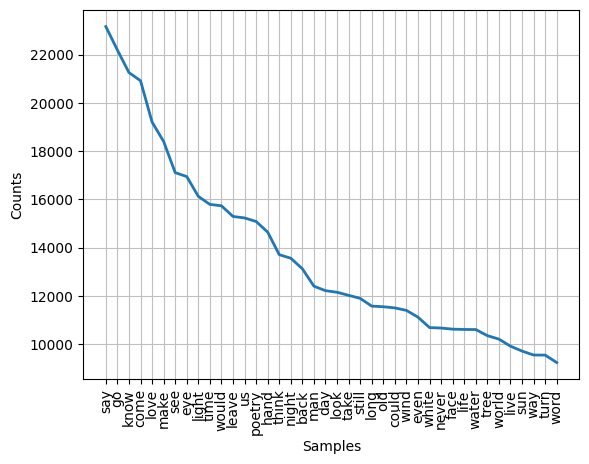

<Axes: xlabel='Samples', ylabel='Counts'>

In [92]:
counts.plot(40, cumulative=False)

Now we are going to see the number of tokens per poem

Average number of tokens per poem: 103.49411502452074


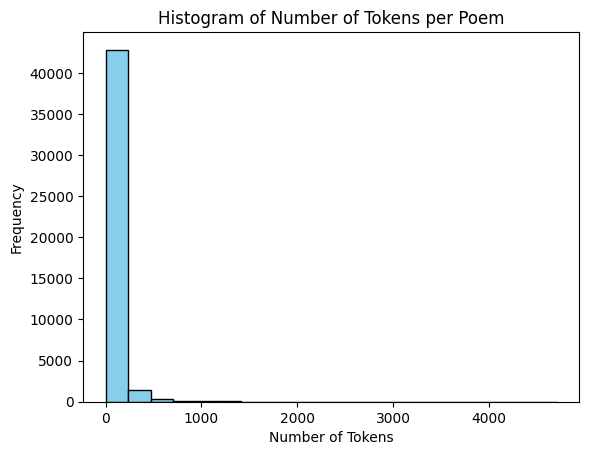

In [93]:
from nltk.tokenize import wordpunct_tokenize

# Tokenize each review and calculate the number of tokens
num_tokens_per_review = [len(review) for review in corpus]

# Calculate the average number of tokens per review
average_tokens_per_review = sum(num_tokens_per_review) / len(num_tokens_per_review)
print("Average number of tokens per poem:", average_tokens_per_review)

import matplotlib.pyplot as plt

# Plot histogram
plt.hist(num_tokens_per_review, bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.title('Histogram of Number of Tokens per Poem')
plt.show()

So we can see that most of the poems have around 103 tokens. Now we are going to use n-gramm detection to join tokens that appear together frequently.

In [94]:
from gensim.models.phrases import Phrases

phrase_model = Phrases(corpus, min_count=2, threshold=20)

print(colored('\n============= First poem in corpus =============', 'blue'))
print(corpus[0])
corpus = [el for el in phrase_model[corpus]] # We populate corpus again
print(colored('\n============= First poem after N-gram replacement =============', 'blue'))
print(corpus[0])


============= First poem in corpus =============
['free', 'without', 'ask', 'quick', 'delivery', 'via', 'overnight', 'male', 'special', 'handle', 'ten', 'year', 'incubation', 'lose', 'pound', 'two', 'weeks', 'cocktails', 'perrier', 'twist', 'azt', 'bactrim', 'broil', 'bacon', 'bits', 'egg', 'lipid', 'quiche', 'brunch', 'tongue', 'ablaze', 'toast', 'point', 'soundless', 'howl', 'talented', 'mind', 'best', 'body', 'generation', 'go', 'smoke', 'act', 'dial', 'get', 'operators', 'stand', 'photograph', 'prove', 'pass', 'away']

============= First poem after N-gram replacement =============
['free', 'without', 'ask', 'quick', 'delivery', 'via', 'overnight', 'male', 'special', 'handle', 'ten', 'year', 'incubation', 'lose', 'pound', 'two_weeks', 'cocktails', 'perrier', 'twist', 'azt', 'bactrim', 'broil', 'bacon', 'bits', 'egg', 'lipid', 'quiche', 'brunch', 'tongue', 'ablaze', 'toast', 'point', 'soundless', 'howl', 'talented', 'mind', 'best', 'body', 'generation', 'go', 'smoke', 'act', 'dial'

In [95]:
data['clean_tokens'] = corpus

To be able to work with the corpus, we need to vectorize all its documents. To do so, there are two steps we need to carry out:

- Calculate the dictionary
- Transform the documents using the dictionary

In [96]:
from gensim.corpora import Dictionary

# Create dictionary of tokens
D = Dictionary(corpus)
n_tokens = len(D)

print('The positive dictionary contains', n_tokens, 'terms')
print('First terms in the dictionary:')
for n in range(10):
    print(str(n), ':', D[n])

The positive dictionary contains 140393 terms
First terms in the dictionary:
0 : ablaze
1 : act
2 : ask
3 : away
4 : azt
5 : bacon
6 : bactrim
7 : best
8 : bits
9 : body


Now we are going to filter tokens that appears just once in a poem, and then see what is the most common and less common tokens.

Number of tokens appearing in exactly one document: 61024
Most common token: go
Least common token: intergenerational


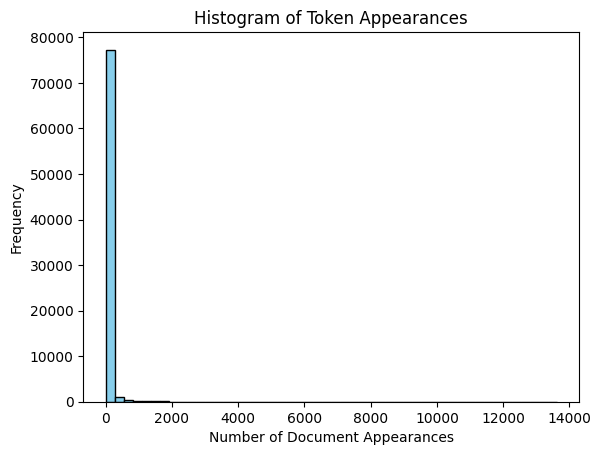

In [97]:
# Count the number of documents where each token appears
token_ndocs = {}
for doc in corpus:
    unique_tokens = set(doc)
    for token in unique_tokens:
        token_ndocs[token] = token_ndocs.get(token, 0) + 1

# Create DataFrame from token_ndocs
df_token_ndocs = pd.DataFrame(token_ndocs.items(), columns=['token', 'ndocs'])

# Sort the DataFrame by ndocs
df_token_ndocs_sorted = df_token_ndocs.sort_values(by='ndocs', ascending=False)

# Count tokens appearing in exactly one document
tokens_in_one_doc = df_token_ndocs_sorted[df_token_ndocs_sorted['ndocs'] == 1]
num_tokens_in_one_doc = len(tokens_in_one_doc)

# Remove tokens appearing in exactly one document
df_token_ndocs_filtered = df_token_ndocs_sorted[df_token_ndocs_sorted['ndocs'] > 1]

# Most and least common tokens
most_common_token = df_token_ndocs_filtered.iloc[0]['token']
least_common_token = df_token_ndocs_filtered.iloc[-1]['token']

print("Number of tokens appearing in exactly one document:", num_tokens_in_one_doc)
print("Most common token:", most_common_token)
print("Least common token:", least_common_token)

# Plot histogram of token appearances
plt.hist(df_token_ndocs_filtered['ndocs'], bins=50, color='skyblue', edgecolor='black')
plt.xlabel('Number of Document Appearances')
plt.ylabel('Frequency')
plt.title('Histogram of Token Appearances')
plt.show()


Next, we will filter out terms that appear in too few or too many of the documents in the dataset. This makes sense because:

terms that appear in most documents are probably not very informative in the general context of a particular corpus
terms that appear in a very reduced number of documents are not useful to find repetitive patterns across documents. In fact, in many cases, we find that many of the words that are eliminated for this reason can be typos.

In [145]:
no_below = 10 # Minimum number of documents to keep a term in the dictionary
no_above = .75 # Maximum proportion of documents in which a term can appear to be kept in the dictionary

D.filter_extremes(no_below=no_below,no_above=no_above)
n_tokens = len(D)

print('The dictionary contains', n_tokens, 'terms')

The dictionary contains 22567 terms


In [146]:
corpus_def = []
for sent in corpus:
  aux = [token for token in sent if token in D.token2id.keys()]
  corpus_def.append(aux)

data['clean_tokens'] = corpus_def

In [147]:
data.head(5)

title                   author  \
0   The 80&rsquo;s Miracle Diet          By Melvin Dixon   
1             All Saints&rsquo;  By Corey Van Landingham   
2  And These Are Just a Few ...          By Melvin Dixon   
3                          ASMR  By Corey Van Landingham   
4                          ASMR  By Corey Van Landingham   

                                          categories  \
0                     ['Living', 'Health & Illness']   
1                                                 []   
2  ['Living', 'Health & Illness', 'Social Comment...   
3                                                 []   
4                                                 []   

                                        clean_tokens  
0  [free, without, ask, quick, delivery, via, ove...  
1  [caravaggio, face, sink, pumpkin, bulbs, rot, ...  
2  [poem, epidemic, dead, live, remember, neighbo...  
3  [climb, mountain, delight, world, thin, meridi...  
4  [hello, tonight, trace, static, bough, cool, s...

## Bag-Of-Words (BoW)

Now we are going to create the BoW representation of our corpus

In [148]:
poems_bow = [D.doc2bow(doc) for doc in corpus]

n_poem = 1000
print(colored('============= Poem (lemmas) =============', 'blue'))
print(' '.join(corpus[n_poem]))

print(colored('\n============= Sparse vector representation =============', 'blue'))
print(poems_bow[n_poem])

print(colored('\n============= Word counts for the poem =============', 'blue'))
word_counts = list(map(lambda x: (D[x[0]], x[1]), poems_bow[n_poem]))
print(word_counts)

============= Poem (lemmas) =============
flesh breath soul begin rise eve_eve ness even balance man wo man even lord even eve begin yeses paradigm mourn sorrow door open another close prayers wish forever transform transformation life genealogy ways ways silver golden leave madrigal tree sing drift fall away tongue illuminate every man great forevermore small everyman heel souls bruise crucifixion resurrection transfiguration translations begin breath leave flesh yet consciousness mystery reform inform end reborn wish beginnings_end life eternity forever transform

============= Sparse vector representation =============
[(3, 1), (37, 1), (68, 3), (70, 1), (116, 3), (132, 2), (222, 1), (261, 1), (284, 1), (332, 1), (346, 1), (397, 1), (422, 1), (445, 1), (455, 1), (681, 1), (683, 1), (762, 2), (840, 2), (890, 1), (1134, 1), (1164, 1), (1199, 2), (1246, 1), (1281, 3), (1293, 2), (1379, 1), (1407, 1), (1614, 1), (1834, 2), (1875, 2), (2083, 1), (2595, 1), (2726, 1), (2793, 1), (3018, 1)

<ipython-input-182-bfbcff5a3b0b>:12: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(words, counts, use_line_collection=True)


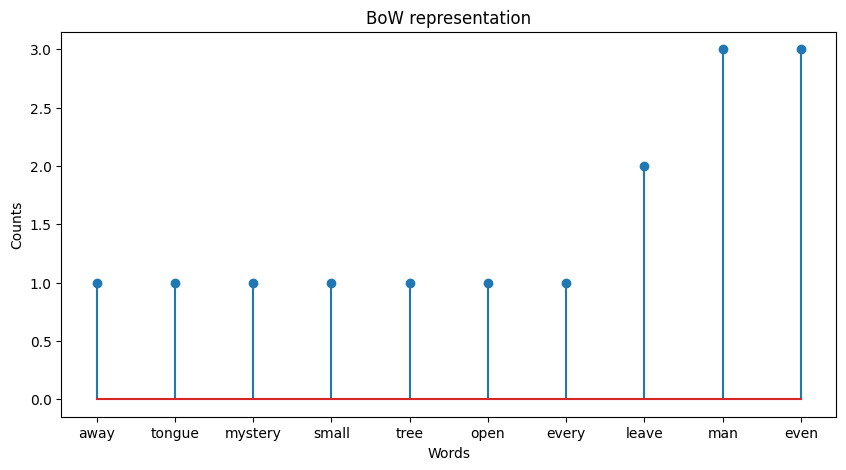

In [182]:
# Your list_word_counts
list_word_counts = [(D[doc_bow[0]], doc_bow[1]) for doc_bow in poems_bow[1000][:10]]

# Sort list_word_counts based on counts in descending order
list_word_counts_sorted = sorted(list_word_counts, key=lambda x: x[1], reverse=False)

# Unzip the sorted list_word_counts
(words, counts) = zip(*list_word_counts_sorted)

# Plot the sorted BoW representation
plt.figure(figsize=(10,5))
plt.stem(words, counts, use_line_collection=True)
plt.title("BoW representation")
plt.xlabel('Words')
plt.ylabel('Counts')
plt.show()

## TF-IDF vectorization

In [149]:
from gensim.models import TfidfModel

tfidf = TfidfModel(poems_bow)

In [150]:
poems_tfidf = tfidf[poems_bow]
n_poem = 1000
print(colored('============= TFIDF representation for the poem =============', 'blue'))
print(poems_tfidf[n_poem])

print(colored('\n============= TFIDF applying the transformation only to the document =============', 'blue'))
print(tfidf[poems_tfidf[n_poem]])

============= TFIDF representation for the poem =============
[(3, 0.050096798166969464), (37, 0.07129720996746516), (68, 0.13095476836460687), (70, 0.10797052232286695), (116, 0.12387731159534127), (132, 0.06989402458291327), (222, 0.05812360427211215), (261, 0.047357805403032034), (284, 0.05478902722892311), (332, 0.05372071347920703), (346, 0.13541441842590723), (397, 0.07008850147779812), (422, 0.06070573818613721), (445, 0.04994494759029588), (455, 0.11230918441909381), (681, 0.051633496882917455), (683, 0.05732584160895345), (762, 0.1357963152674313), (840, 0.1638649433529593), (890, 0.05674138043292383), (1134, 0.04848806429335477), (1164, 0.05484034902030801), (1199, 0.14554257349861754), (1246, 0.09144039235826827), (1281, 0.184750254178646), (1293, 0.08847422232217933), (1379, 0.06008029196383299), (1407, 0.14281833203149885), (1614, 0.08253127549760712), (1834, 0.15443712520433145), (1875, 0.26036822065612647), (2083, 0.07012688299817418), (2595, 0.07589448850516987), (2726,

<ipython-input-183-837407e83462>:12: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(words, counts, use_line_collection=True)


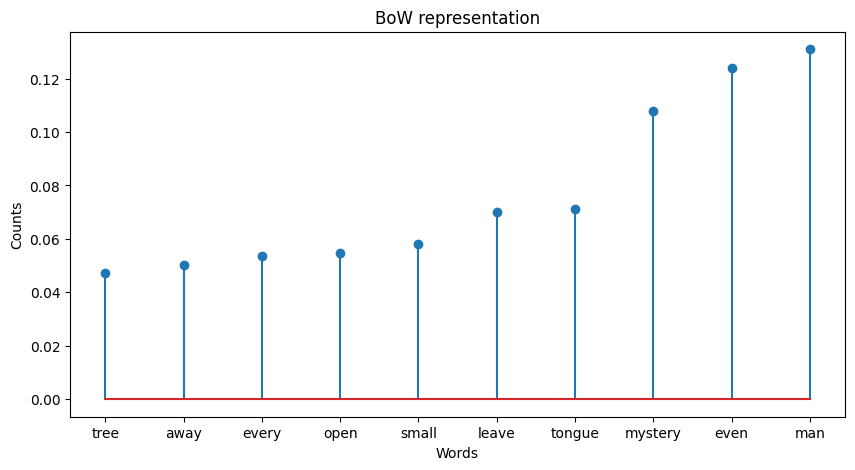

In [183]:
# Your list_word_counts
list_tf = [(D[doc_tf[0]], doc_tf[1]) for doc_tf in poems_tfidf[1000][:10]]

# Sort list_word_counts based on counts in descending order
list_word_counts_sorted = sorted(list_tf, key=lambda x: x[1], reverse=False)

# Unzip the sorted list_word_counts
(words, counts) = zip(*list_word_counts_sorted)

# Plot the sorted BoW representation
plt.figure(figsize=(10,5))
plt.stem(words, counts, use_line_collection=True)
plt.title("BoW representation")
plt.xlabel('Words')
plt.ylabel('Counts')
plt.show()

## Word2Vec

In [151]:
from gensim.models import Word2Vec

word2vec_model = Word2Vec(corpus, vector_size=100, window=5, min_count=1, workers=4)

poem_word2vec = word2vec_model.wv[corpus[n_poem]]

In [152]:
print(colored('============= Word2Vec representation for the poem =============', 'blue'))
print(poem_word2vec)

============= Word2Vec representation for the poem =============
[[-0.6343059  -1.6604979   0.24689619 ... -0.45868406 -0.23023629
   0.15176396]
 [-0.86699647  0.97917414  0.9104767  ...  1.1822128   0.3603325
   2.4032526 ]
 [-0.55471724  0.31886274 -1.4432039  ... -0.5386547   0.5890416
   1.2232908 ]
 ...
 [-0.26553458 -0.36815804 -0.37597755 ...  0.34599856  0.48428825
   0.8112107 ]
 [-0.5455467  -0.4158485  -0.54227895 ...  1.1856794   0.4877506
  -0.15952687]
 [ 0.09113162  0.3198755  -0.06948106 ...  0.10027131  0.35754108
  -0.12768875]]


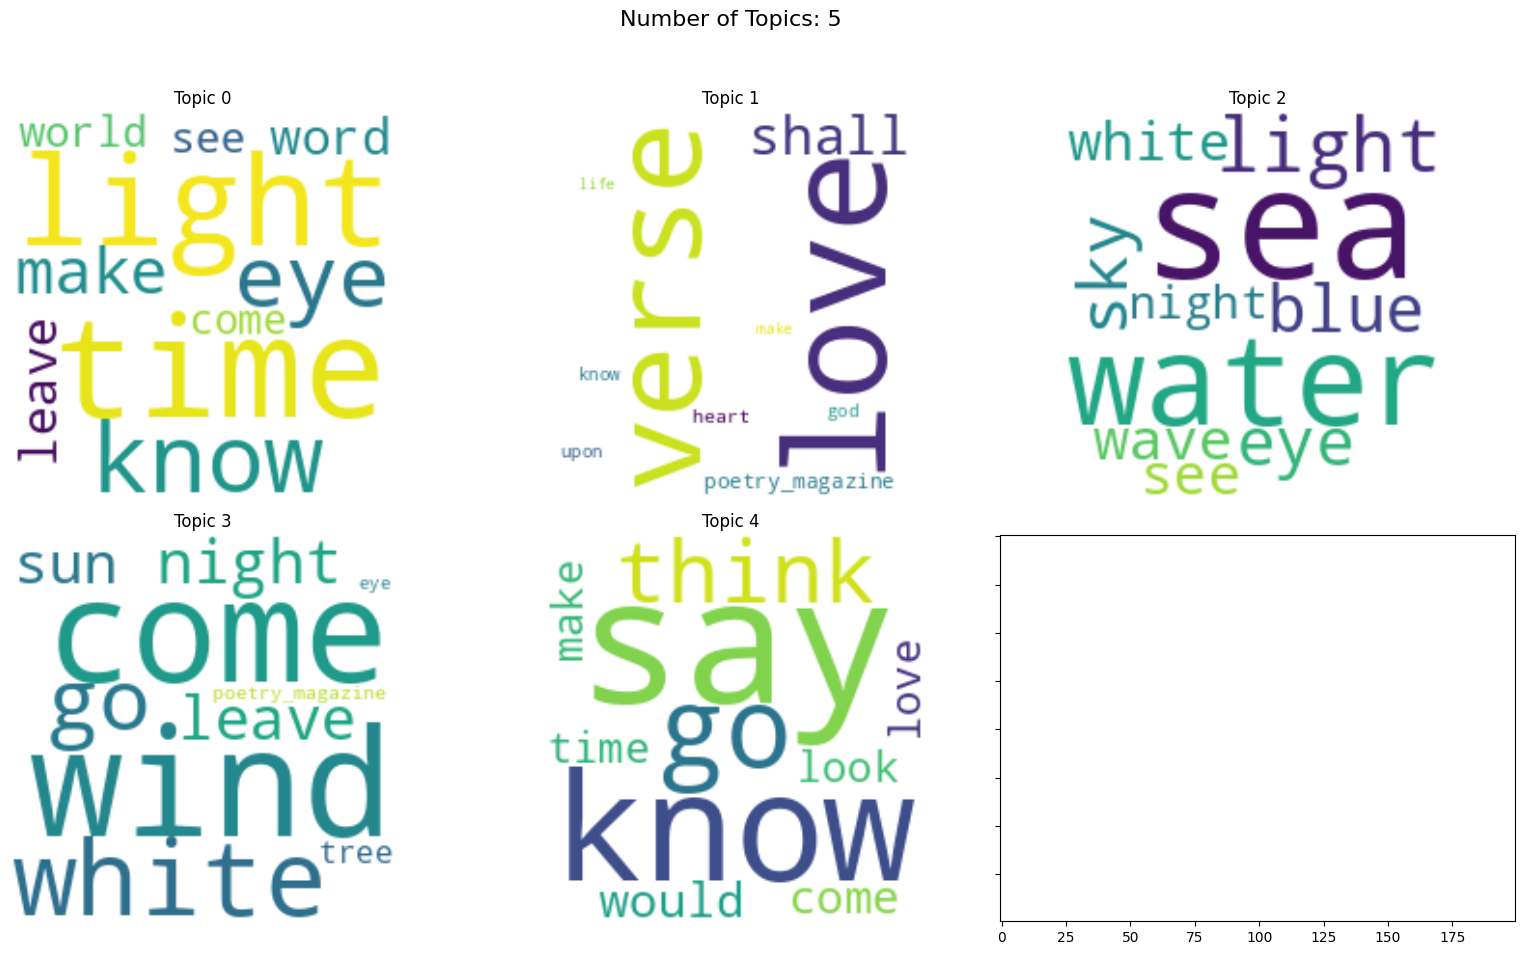

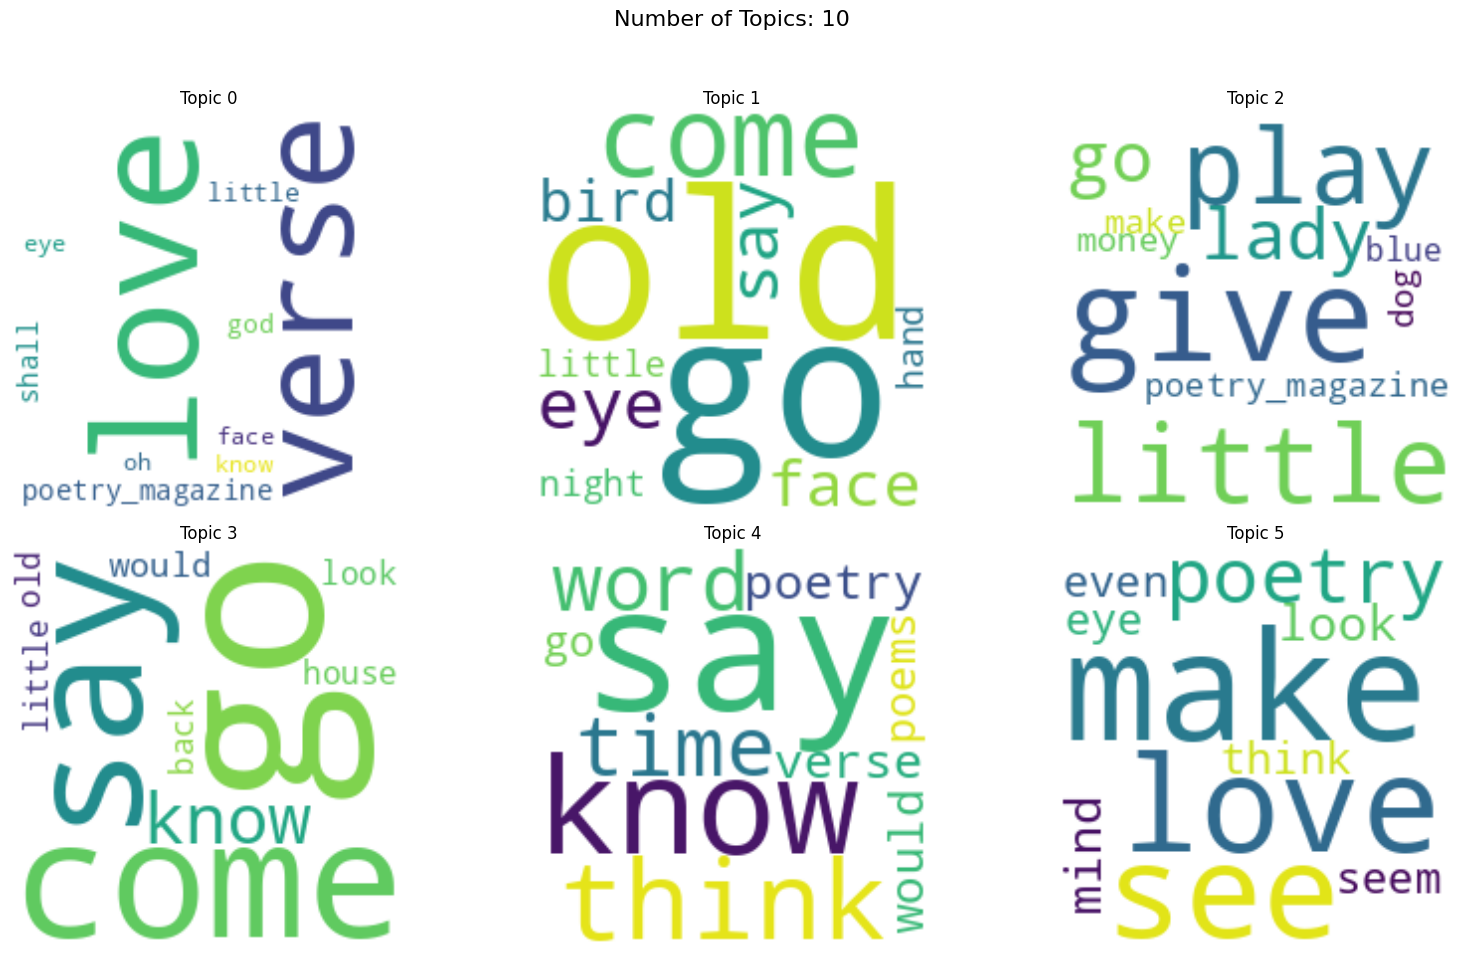

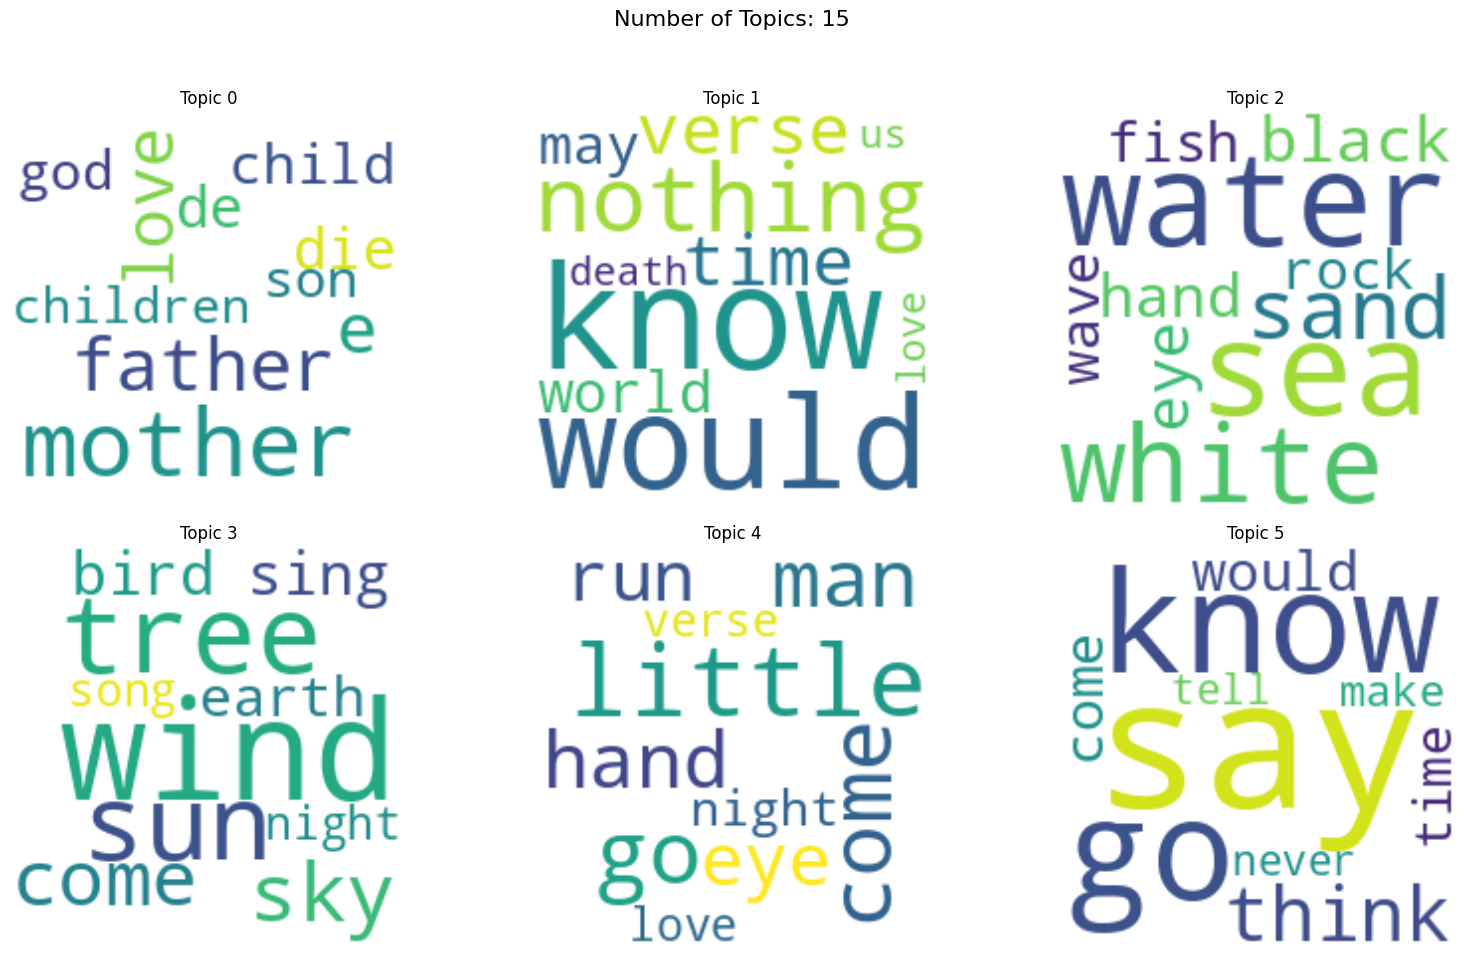

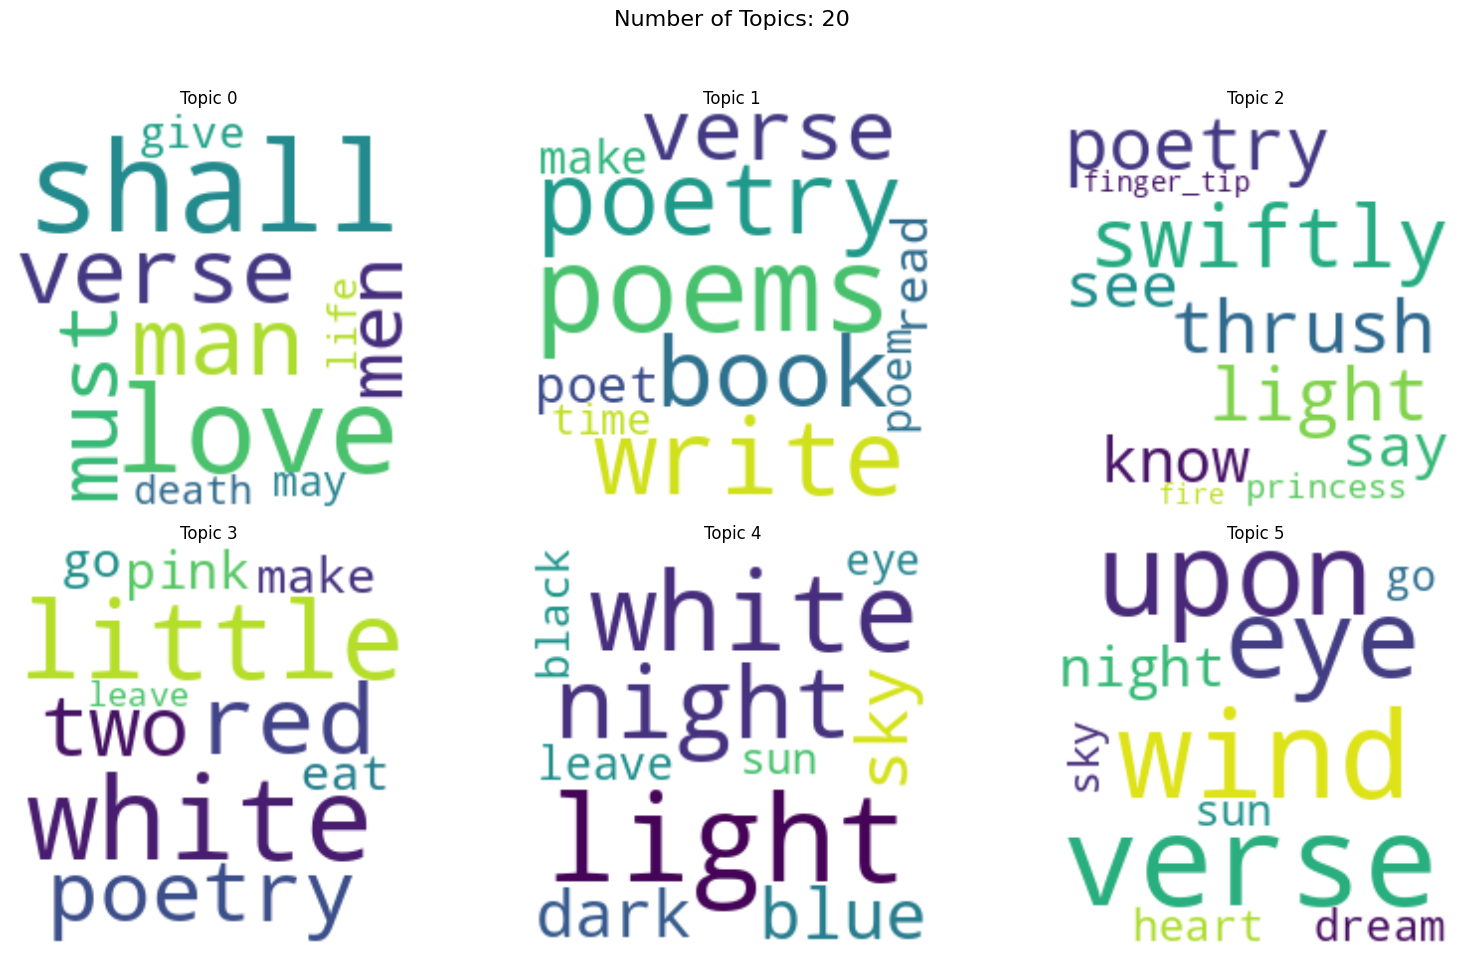

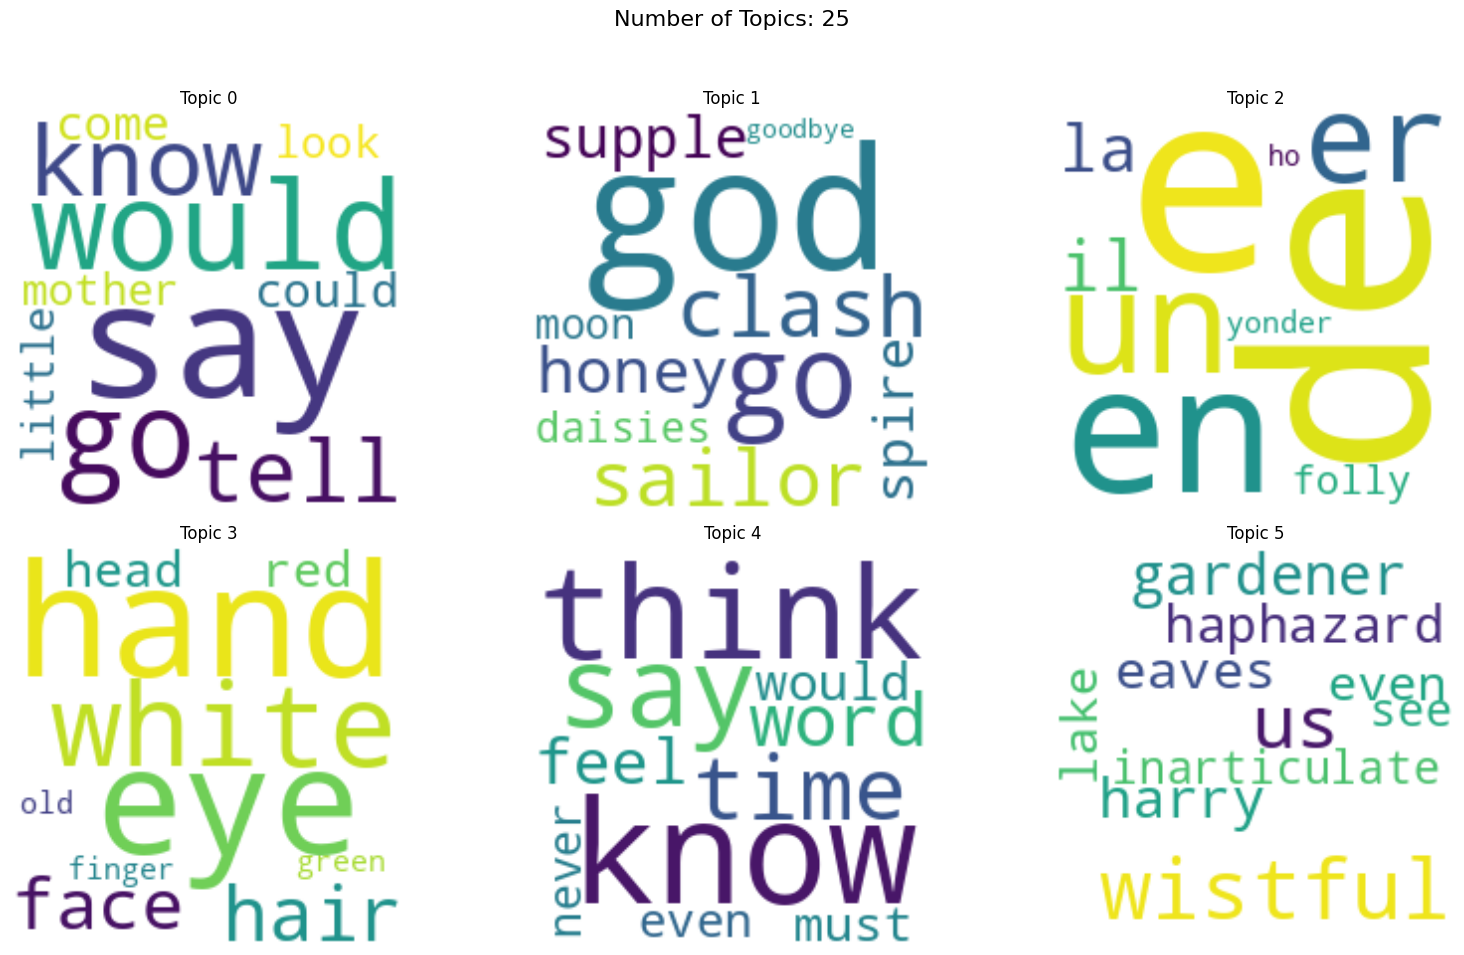

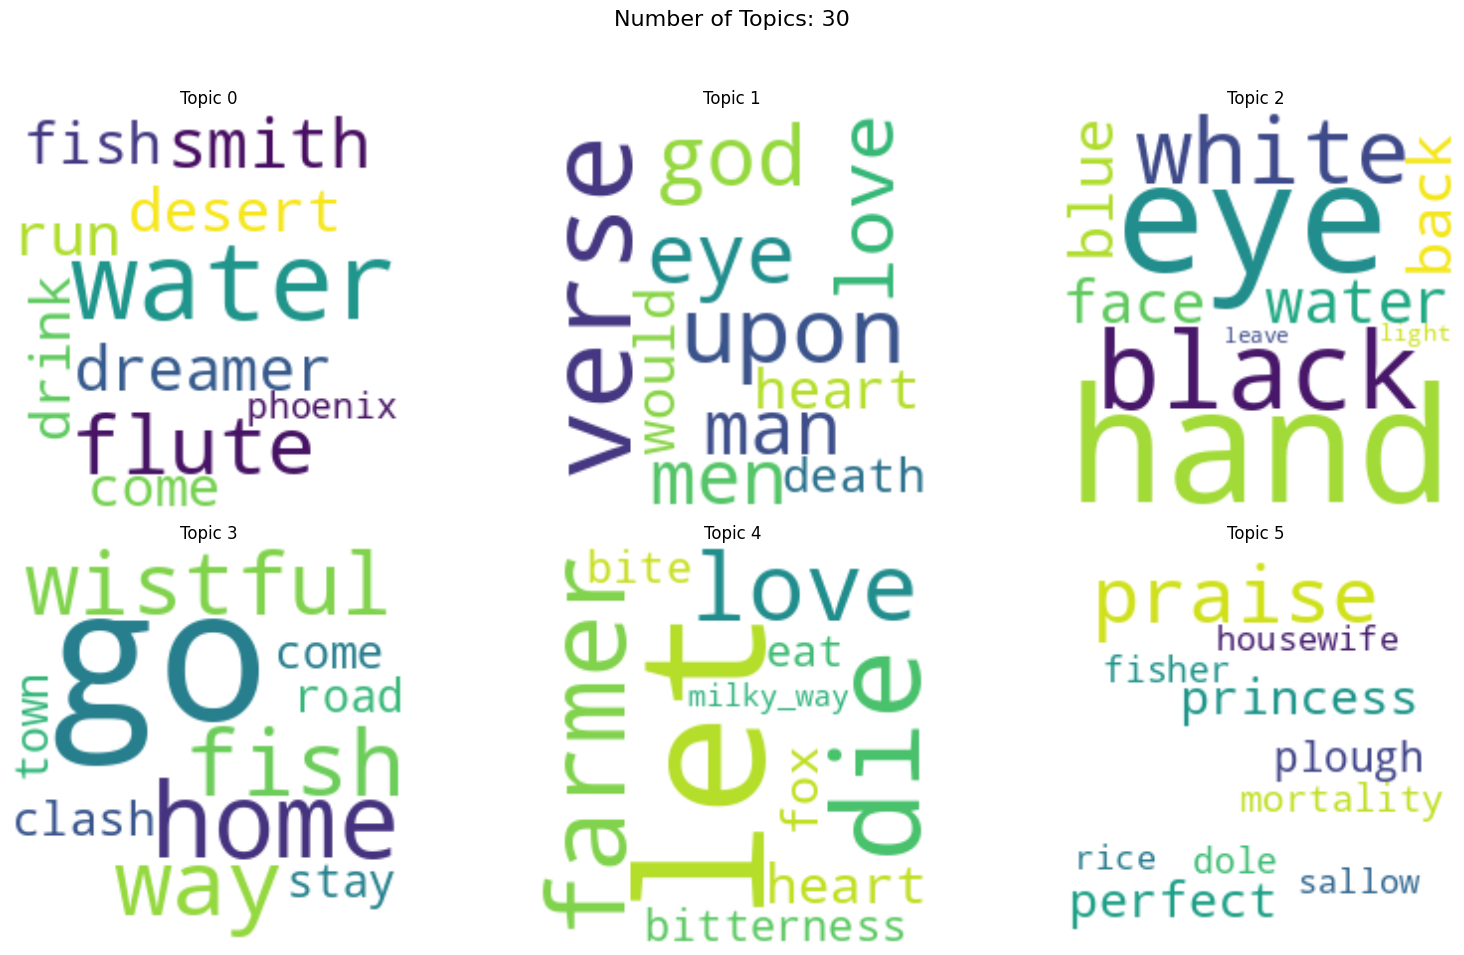

In [185]:
from gensim.models.ldamodel import LdaModel


# Define the range of num_topics to try
num_topics_to_try = [5, 10, 15, 20, 25, 30]

# Loop through each num_topics and generate word clouds
for num_topics in num_topics_to_try:
    ldag = LdaModel(corpus=poems_bow, id2word=D, num_topics=num_topics)  # Create LDA model

    # Create a figure and axes for plotting
    fig, axes = plt.subplots(2, 3, figsize=(16, 10), sharex=True, sharey=True)
    axes = axes.flatten()  # Flatten the axes array for easier iteration

    # Loop through each topic and generate a word cloud for it
    for i, ax in enumerate(axes):
        if i < num_topics:  # Check if the topic index is within bounds
            # Build a dataframe with columns 'token' and 'weight' for the current topic
            topic_tokens = ldag.show_topic(i, topn=10)
            df = pd.DataFrame(topic_tokens, columns=['token', 'weight'])

            # Convert the top words to a dictionary for word cloud generation
            wordcloud_dict = {row['token']: row['weight'] for _, row in df.iterrows()}

            # Generate the word cloud
            wordcloud = WordCloud(width=200, height=200, background_color='white').generate_from_frequencies(wordcloud_dict)

            # Plot the word cloud on the current subplot
            ax.imshow(wordcloud, interpolation='bilinear')
            ax.set_title('Topic ' + str(i))
            ax.axis('off')

    fig.suptitle('Number of Topics: ' + str(num_topics), fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to avoid overlap
    plt.show()

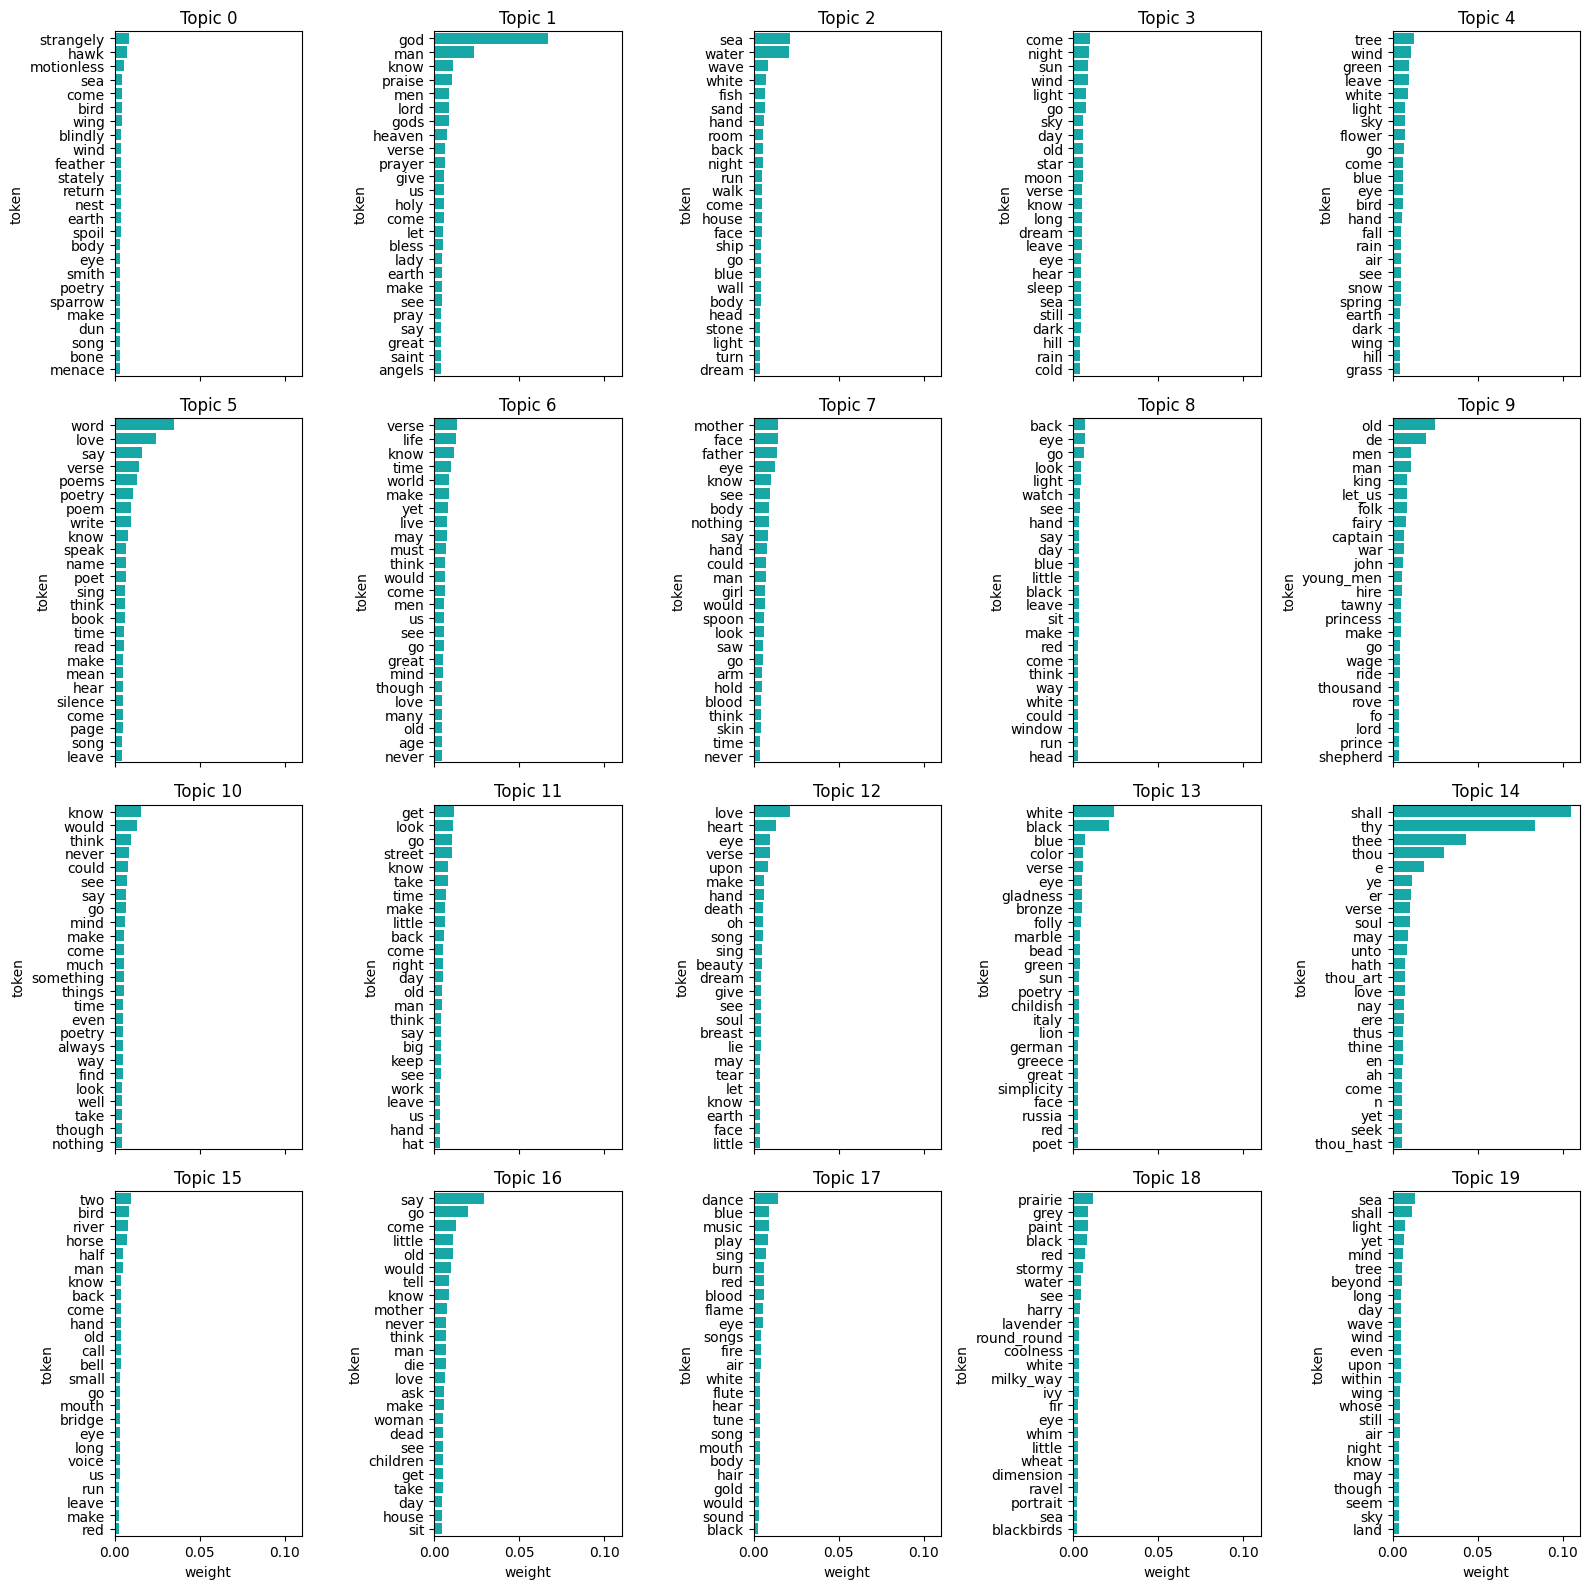

In [155]:
topn = 25

fig, axes = plt.subplots(4, 5, figsize=(16, 16), sharex=True)

for i in range(4):
    for j in range(5):
        # Calculate the starting topic number for the current subplot
        topic_num = i * 5 + j

        # Build a dataframe with columns 'token' and 'weight' for the current topic
        topic_tokens = ldag.show_topic(topic_num, topn=topn)
        df = pd.DataFrame(topic_tokens, columns=['token', 'weight'])

        # Plot the top words for the current topic
        sns.barplot(x='weight', y='token', data=df, color='c', orient='h', ax=axes[i][j])
        axes[i][j].set_title('Topic ' + str(topic_num))

plt.tight_layout()
plt.show()

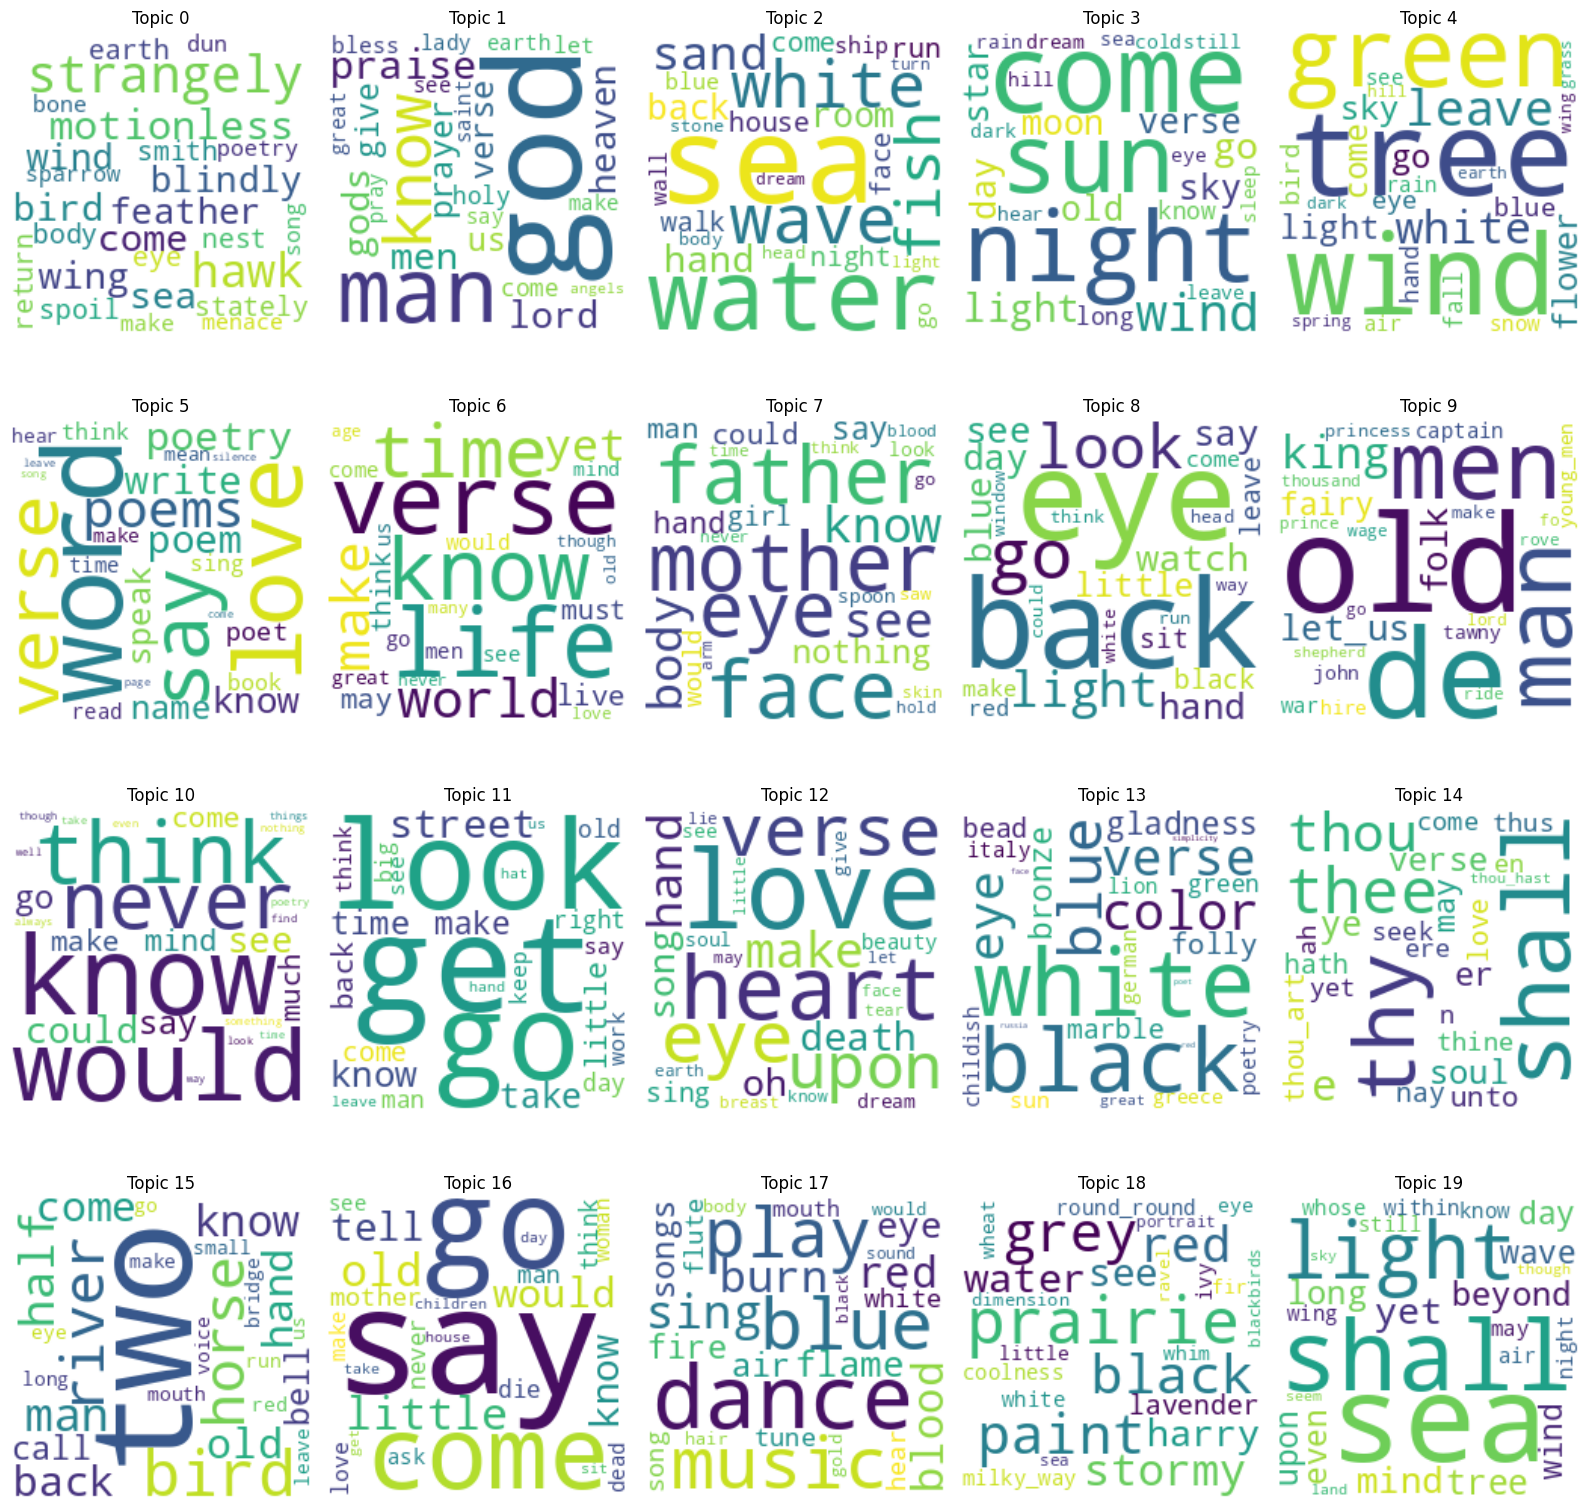

In [156]:
# Create a figure and axes for plotting
fig, axes = plt.subplots(4, 5, figsize=(16, 16), sharex=True)

# Loop through each topic and generate a word cloud for it
for i in range(4):
    for j in range(5):
        # Calculate the starting topic number for the current subplot
        topic_num = i * 5 + j

        # Build a dataframe with columns 'token' and 'weight' for the current topic
        topic_tokens = ldag.show_topic(topic_num, topn=topn)
        df = pd.DataFrame(topic_tokens, columns=['token', 'weight'])

        # Convert the top words to a dictionary for word cloud generation
        wordcloud_dict = {row['token']: row['weight'] for index, row in df.iterrows()}

        # Generate the word cloud
        wordcloud = WordCloud(width=200, height=200, background_color='white').generate_from_frequencies(wordcloud_dict)

        # Plot the word cloud on the current subplot
        ax = axes[i][j]
        ax.imshow(wordcloud, interpolation='bilinear')
        ax.set_title('Topic ' + str(topic_num))
        ax.axis('off')

plt.tight_layout()
plt.show()

# Classification Dataset Preprocessing

In [220]:
#df = pd.read_csv('Datasets/classification_data.csv', encoding='latin-1', dtype=str)
df = pd.read_csv('/content/drive/MyDrive/classification_data.csv', encoding='latin-1')
# Drop rows with missing values in the 'poem' column
df = df.dropna(subset=['poem'])

In [221]:
df.head()

id                                              title  \
0   43926             The Canterbury Tales: General Prologue   
1   44295  Confessio Amantis, Book III: The Tale of Apoll...   
2  159137              Ego Dormio: [All perishes and passes]   
3   44442                               The King&#39;s Quire   
4   43936                             The Parlement of Fowls   

                    author                                            snippet  \
0      By Geoffrey Chaucer  Whan that Aprille with his shour<strong>e</str...   
1            By John Gower                            Appolinus his levE tok,   
2         By Richard Rolle  [Alle perisches and passes pat we with eghe see]    
3  By James I, Of Scotland               Bewailing in my chamber thus allone,   
4      By Geoffrey Chaucer   Now welcome, somer, with thy sonne soft<b>e</b>,   

                                                link  \
0  https://www.poetryfoundation.org/poems/43926/t...   
1  https://www.poetryfoundation.org/poems/44295/c...   
2  https://www.poetryfoundation.org/poems/159137/...   
3  https://www.poetryfoundation.org/poems/44442/t...   
4  https://www.poetryfoundation.org/poems/43936/t...   

                                          categories          period  \
0  ['The Body', 'The Mind', 'Love', 'Activities',...  Middle English   
1                                                 []  Middle English   
2  ['Love', 'Classic Love', 'Religion', 'Christia...  Middle English   
3                                                 []  Middle English   
4  ['Love', 'Romantic Love', 'Relationships', 'Na...  Middle English   

                                                poem  
0  Here bygynneth the Book of the tales of Caunte...  
1  Appolinus his leve tok, To God and al the lond...  
2  [Alle perisches and passes pat we with eghe se...  
3  Bewailing in my chamber thus allone, Despeired...  
4  (excerpt) Now welcome, somer, with thy sonne s...

In [222]:
columns_to_drop = ["id", "snippet", "link"]
df.drop(columns=columns_to_drop, inplace=True)

In [223]:
df.head()

title                   author  \
0             The Canterbury Tales: General Prologue      By Geoffrey Chaucer   
1  Confessio Amantis, Book III: The Tale of Apoll...            By John Gower   
2              Ego Dormio: [All perishes and passes]         By Richard Rolle   
3                               The King&#39;s Quire  By James I, Of Scotland   
4                             The Parlement of Fowls      By Geoffrey Chaucer   

                                          categories          period  \
0  ['The Body', 'The Mind', 'Love', 'Activities',...  Middle English   
1                                                 []  Middle English   
2  ['Love', 'Classic Love', 'Religion', 'Christia...  Middle English   
3                                                 []  Middle English   
4  ['Love', 'Romantic Love', 'Relationships', 'Na...  Middle English   

                                                poem  
0  Here bygynneth the Book of the tales of Caunte...  
1  Appolinus his leve tok, To God and al the lond...  
2  [Alle perisches and passes pat we with eghe se...  
3  Bewailing in my chamber thus allone, Despeired...  
4  (excerpt) Now welcome, somer, with thy sonne s...

### Separate Languages, filter out non-english poems

In [224]:
# Call the function to separate language
classif_english_df, classif_other_lang_df = separate_language(df, 'poem')

In [225]:
# i want to check the size of both dfs
print(classif_english_df.shape)
print(classif_other_lang_df.shape)

(5525, 5)
(7, 5)


As before, the proportion of non-english poems is pretty low, and here we only have 8 of them. As we have the english translated version already in the data, we remove can them.

In [226]:
classif_english_df.head()

title                   author  \
0             The Canterbury Tales: General Prologue      By Geoffrey Chaucer   
1  Confessio Amantis, Book III: The Tale of Apoll...            By John Gower   
2              Ego Dormio: [All perishes and passes]         By Richard Rolle   
3                               The King&#39;s Quire  By James I, Of Scotland   
4                             The Parlement of Fowls      By Geoffrey Chaucer   

                                          categories          period  \
0  ['The Body', 'The Mind', 'Love', 'Activities',...  Middle English   
1                                                 []  Middle English   
2  ['Love', 'Classic Love', 'Religion', 'Christia...  Middle English   
3                                                 []  Middle English   
4  ['Love', 'Romantic Love', 'Relationships', 'Na...  Middle English   

                                                poem  
0  Here bygynneth the Book of the tales of Caunte...  
1  Appolinus his leve tok, To God and al the lond...  
2  [Alle perisches and passes pat we with eghe se...  
3  Bewailing in my chamber thus allone, Despeired...  
4  (excerpt) Now welcome, somer, with thy sonne s...

In [205]:
classif_other_lang_df.head()

title              author  \
3090                              "Lettres d'un Soldat"  By Wallace Stevens   
3579  The Song of the Nightingale is Like the Scent ...         By Mina Loy   
4156  The Murder of Two Men by a Young Kid Wearing L...  By Kenneth Patchen   
5367                                 ("car swerves...")     By Aram Saroyan   
5429                                ("j;u;n;g;l;e;...")     By Aram Saroyan   

                                             categories  \
3090                                                 []   
3579  ['Relationships', 'Pets', 'Nature', 'Animals',...   
4156  ['Living', 'Death', 'Social Commentaries', 'Cr...   
5367                                                 []   
5429                                                 []   

                                period  \
3090                            Modern   
3579                            Modern   
4156                              Beat   
5367  New York School (2nd Generation)   
5429  New York School (2nd Generation)   

                                                   poem  
3090  PBoetry ett get  MAY, 1918     LETTRES DUN SOL...  
3579  Nightingale singinggale of Nanking Singmystery...  
4156  Wait. Wait. Wait. Wait. Wait. Wait. Wait. W a ...  
5367  ARAM SAROYAN  jruinsgilje  car swerves, injure...  
5429  ARAM SAROYAN  jruinsgilje  car swerves, injure...

### Save the Classification English DataFrame

In [240]:
classif_english_df.to_csv('classif_english_df.csv', encoding='latin-1', index=False,errors = "ignore", quoting=1) # CAREFUL, you can overwrite your previous dataset, UPDATE the name when used

#other languages dataset can not be codified and as we are not going to use it we dont care about it
classif_other_lang_df.to_csv('classif_other_lang_df.csv',encoding='latin-1', index=False) # CAREFUL, you can overwrite your previous dataset, UPDATE the name when used

In [241]:
df = pd.read_csv('classif_english_df.csv', encoding='latin-1')

In [242]:
df2 = df.copy()
df2['poem'] = df['poem'].apply(lambda x: wrangle_text(x))

<ipython-input-18-a190bd815777>:19: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "lxml").text


In [243]:
# Apply the prepare_data function to clean the poems
df2['clean_tokens'] = df2['poem'].apply(lambda x: prepare_data(x, tool='lemmatize'))

In [244]:
df2.head()

title                   author  \
0             The Canterbury Tales: General Prologue      By Geoffrey Chaucer   
1  Confessio Amantis, Book III: The Tale of Apoll...            By John Gower   
2              Ego Dormio: [All perishes and passes]         By Richard Rolle   
3                               The King&#39;s Quire  By James I, Of Scotland   
4                             The Parlement of Fowls      By Geoffrey Chaucer   

                                          categories          period  \
0  ['The Body', 'The Mind', 'Love', 'Activities',...  Middle English   
1                                                 []  Middle English   
2  ['Love', 'Classic Love', 'Religion', 'Christia...  Middle English   
3                                                 []  Middle English   
4  ['Love', 'Romantic Love', 'Relationships', 'Na...  Middle English   

                                                poem  \
0  Here bygynneth the Book of the tales of Caunte...   
1  Appolinus his leve tok To God and al the lond ...   
2  Alle perisches and passes pat we with eghe see...   
3  Bewailing in my chamber thus allone Despeired ...   
4  excerpt Now welcome somer with thy sonne softe...   

                                        clean_tokens  
0  [bygynneth, book, tales, caunterbury, whan, ap...  
1  [appolinus, leve, tok, god, al, lond, betok, a...  
2  [alle, perisches, pass, pat, eghe, see, wan, w...  
3  [bewail, chamber, thus, allone, despeired, joy...  
4  [excerpt, welcome, somer, thy, sonne, softe, h...

In [245]:
# remove the column 'poem'
df2 = df2.drop(columns=['poem'])

In [246]:
df2.to_csv('classification_processed.csv', encoding='latin-1', index=False, quoting=1) # CAREFUL, you can overwrite your previous dataset, UPDATE the name when used


# Classification task

In [249]:
df = pd.read_csv('classification_processed.csv', encoding='latin-1')